In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_file = "/content/drive/MyDrive/Grad School-Files/Job Search/WiDS 2024/training.csv"
test_file = "/content/drive/MyDrive/Grad School-Files/Job Search/WiDS 2024/test.csv"

In [4]:
#Import training and test data
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

# Problem Statement

Based on the provided dataset which consists of patients information (age, race, BMI, zip code, breast cancer diagnosis code, metastatic cancer diagnosis code, metastatic cancer treatments, etc.), their geo-demographic data (income, education, rent, race, poverty, …etc), as well as toxic air quality data (Ozone, PM25 and NO2), predict the likelihood of the patient’s Diagnosis Period being less than 90 days .



# Obtain basic information about the dataset

In [7]:
# Print the shape of training and test data
print(train.info())
print("Shape of training data set: ", train.shape)
print("Shape of test data set: ", test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

The training dataset has 83 columns and 12905 total entries. Note that there are two sets of information, patient level data and demographics data. So, let's split the dataset into two: patient level data and demographic data

# Remove columns that have more than half null values

In [10]:
#Remove columns where over half the values are null
null_values = pd.DataFrame(train.isna().sum(), columns=['null_vals']).reset_index()
null_values_sig = null_values[null_values['null_vals'] >= len(train)/2]

train = train.drop(null_values_sig['index'], axis='columns')
test = test.drop(null_values_sig['index'], axis='columns')
print("Shape of training data: ", train.shape)
print("Shape of test data: ", test.shape)

(12823, 80)
(5792, 82)


In [9]:
# Remove rows with more than 2 null values
train.drop(train[train.isnull().sum(axis=1)>2].index,axis=0,inplace=True)
print(train.shape)

(12823, 80)


In [ ]:
#Redefine NaN payer type as no insurance info
train['payer_type'] = train['payer_type'].fillna('UNDEFINED')
test['payer_type'] = train['payer_type'].fillna('UNDEFINED')

In [11]:
#Patient level data
data_patient= pd.concat([train.iloc[:, 0:11], train.iloc[:, train.shape[1]-1]], axis=1)
data_demo = pd.concat([train.iloc[:,0], train.iloc[:, 12:]], axis=1)
data_patient.head(10)

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,West,1
1,349367,White,COMMERCIAL,CA,928,62,F,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,West,1
2,138632,White,COMMERCIAL,TX,760,43,F,C50112,Malignant neoplasm of central portion of left ...,C773,South,1
3,617843,White,COMMERCIAL,CA,926,45,F,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,West,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,1749,"Malignant neoplasm of breast (female), unspeci...",C773,West,0
5,111545,White,MEDICARE ADVANTAGE,NY,141,66,F,1749,"Malignant neoplasm of breast (female), unspeci...",C7981,Northeast,0
6,914071,NaN,COMMERCIAL,CA,900,51,F,C50912,Malignant neoplasm of unspecified site of left...,C779,West,1
7,479368,White,COMMERCIAL,IL,619,60,F,C50512,Malig neoplasm of lower-outer quadrant of left...,C773,Midwest,1
9,155485,NaN,COMMERCIAL,IL,617,64,F,C50912,Malignant neoplasm of unspecified site of left...,C773,Midwest,1
10,875977,NaN,MEDICARE ADVANTAGE,MI,488,67,F,C50412,Malig neoplasm of upper-outer quadrant of left...,C799,Midwest,0


# Patient Level Data Analysis: Training Data

Let us drop the breast cancer description column for now to conduct an exploratory data analysis of patient data without textual information

In [12]:
data_patient = data_patient.drop("breast_cancer_diagnosis_desc", axis='columns')
data_patient.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12823 entries, 0 to 12905
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   patient_id                        12823 non-null  int64 
 1   patient_race                      6473 non-null   object
 2   payer_type                        11044 non-null  object
 3   patient_state                     12823 non-null  object
 4   patient_zip3                      12823 non-null  int64 
 5   patient_age                       12823 non-null  int64 
 6   patient_gender                    12823 non-null  object
 7   breast_cancer_diagnosis_code      12823 non-null  object
 8   metastatic_cancer_diagnosis_code  12823 non-null  object
 9   Region                            12822 non-null  object
 10  DiagPeriodL90D                    12823 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 1.2+ MB


There are four numerical columns: patient_id, patient_zip3, patient_age, bmi, DiagPeriodL90D

The remaining 10 columns contain categorical data

In [13]:
#Separate numerical and cateogrical data
patient_cat = data_patient.select_dtypes(include=['object'])
patient_numerical = data_patient.drop(patient_cat.columns, axis=1)

## Let's look at the categorical data

In [14]:
#Information about categorical patient data
patient_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12823 entries, 0 to 12905
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   patient_race                      6473 non-null   object
 1   payer_type                        11044 non-null  object
 2   patient_state                     12823 non-null  object
 3   patient_gender                    12823 non-null  object
 4   breast_cancer_diagnosis_code      12823 non-null  object
 5   metastatic_cancer_diagnosis_code  12823 non-null  object
 6   Region                            12822 non-null  object
dtypes: object(7)
memory usage: 801.4+ KB


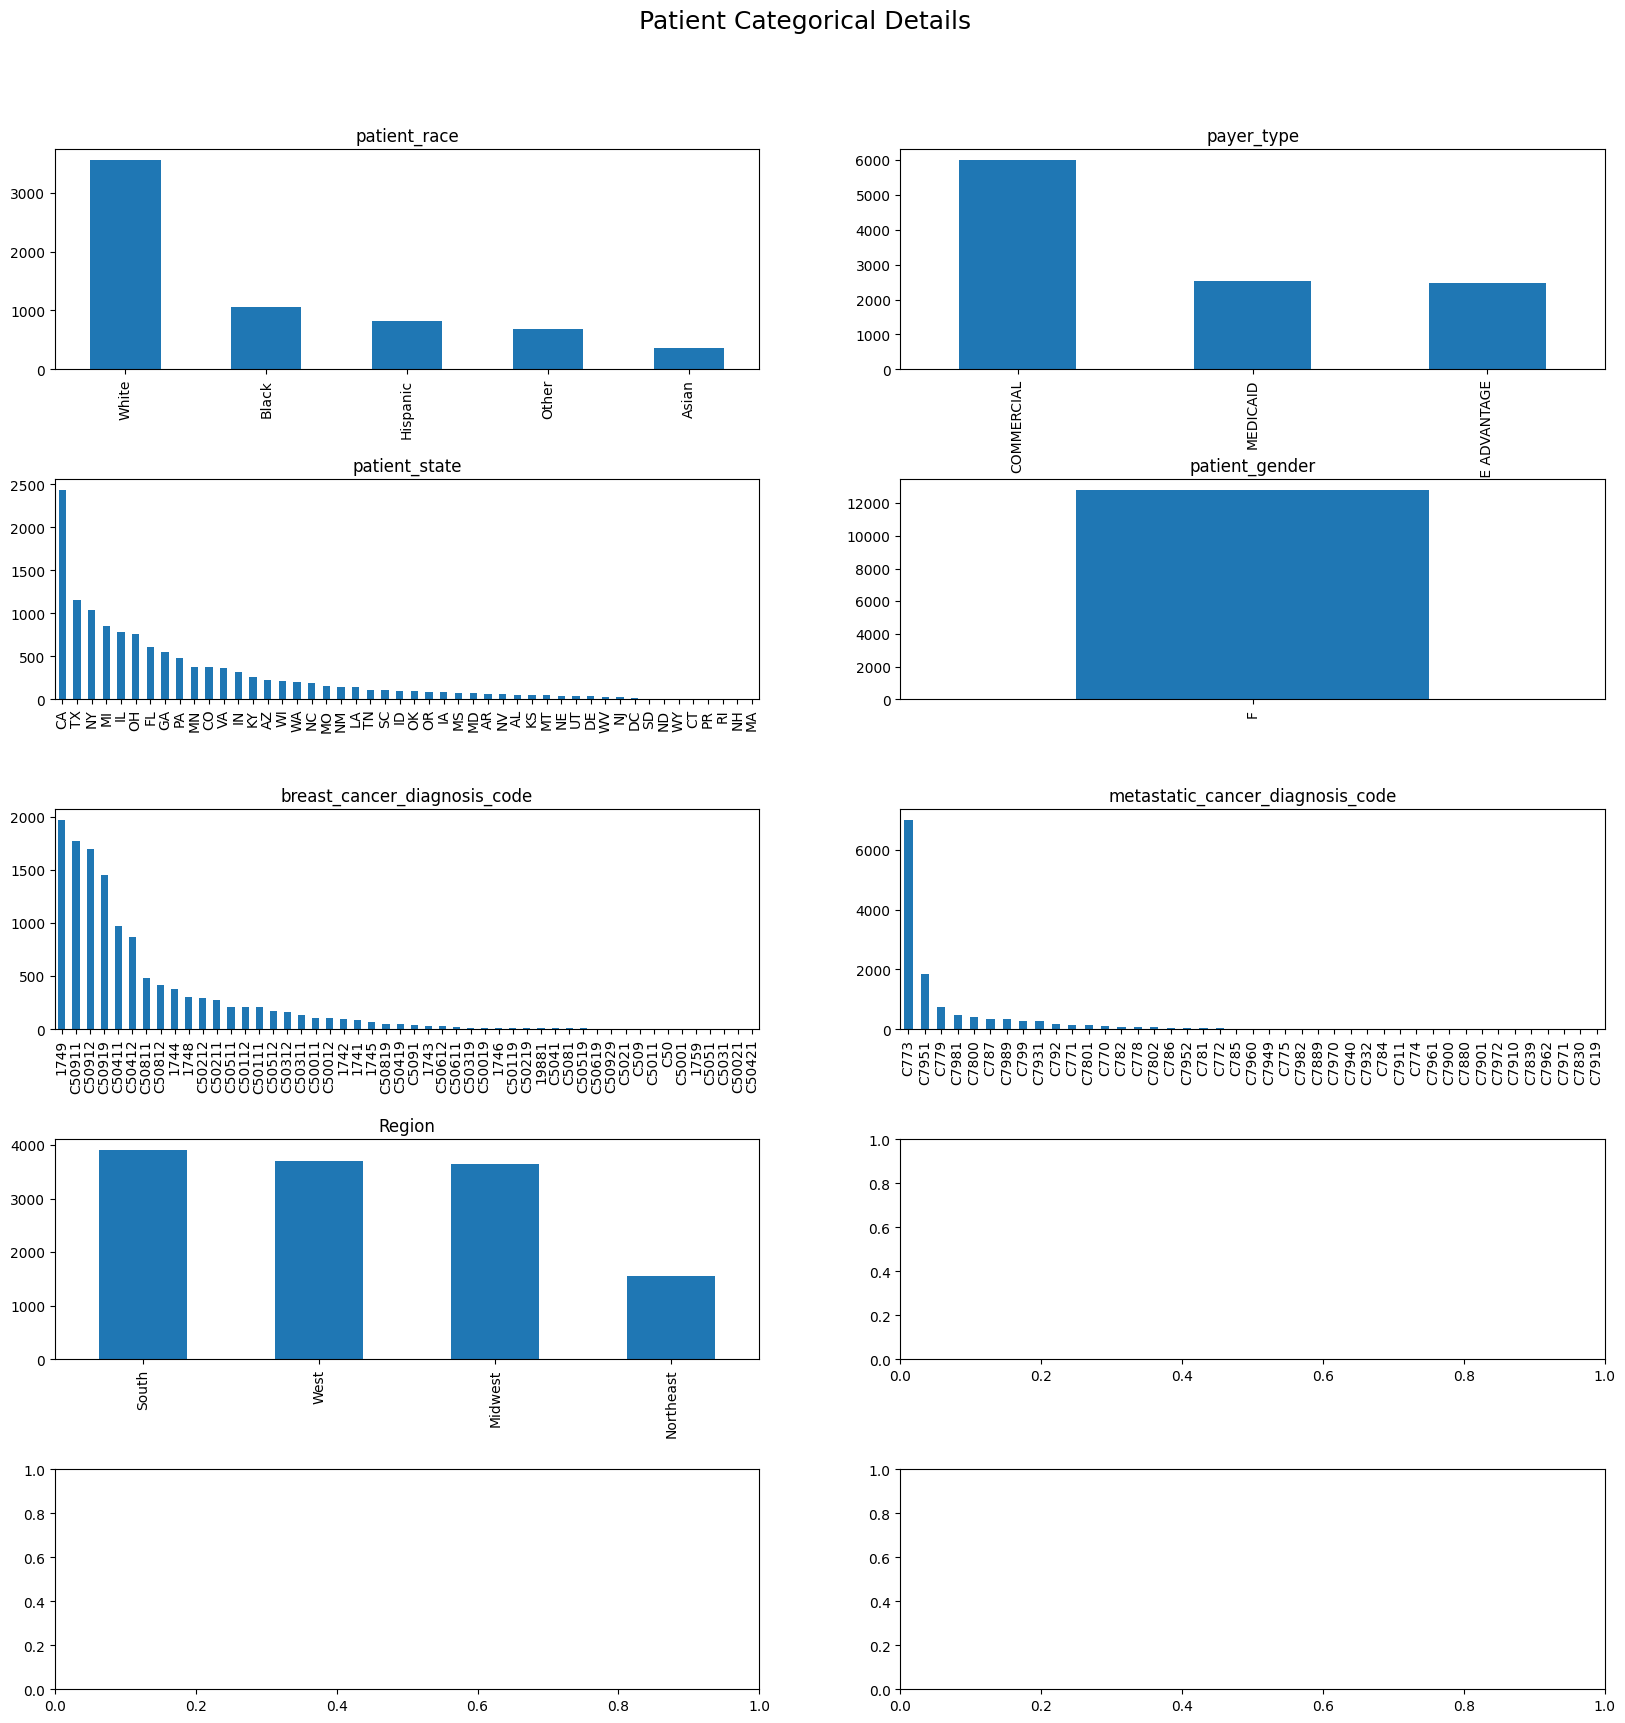

In [15]:
# define subplot grid
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Patient Categorical Details", fontsize=18, y=0.95)

# loop through tickers and axes
for column, ax in zip(patient_cat.columns, axs.ravel()):
    # filter df for ticker and plot on specified axes
    patient_cat[column].value_counts().plot(kind = 'bar', ax=ax)

    # chart formatting
    ax.set_title(column)
    ax.set_xlabel("")
plt.show()

## Observations

1. Patient_race: The dataset is biased towards White patients
2. Payer_type: The dataset is biased towards Commercial payers
3. Patient_state: The dataset is biased towards patients from California
4. Patient_gender: All patients are female, therefore this column can be dropped as it doesn't add anything more

5. Breast Cancer diagnosis code: A few codes are overrepresented (1749, C50911, C50912, C50919, C50411, C50412)

6. Metastatic Cancer diagnosis code: A few codes are overrepresented (C773, C7951)

7. Metastatic_first_novel_treatment: the two treatments are almost equally represented.

8. Metastatic_first_novel_treatment_type: Only one treatment type, so this column can be dropped

9. Region: The Northeast region is not as well represented

10. Division: Not all regions are equally represented

## Next Steps:

1. Drop patient_gender and Metastatic_first_novel_treatment_type from the dataset

In [16]:
train = train.drop(['patient_gender'], axis='columns')

## Let's look at the numerical categories

In [17]:
patient_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12823 entries, 0 to 12905
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   patient_id      12823 non-null  int64
 1   patient_zip3    12823 non-null  int64
 2   patient_age     12823 non-null  int64
 3   DiagPeriodL90D  12823 non-null  int64
dtypes: int64(4)
memory usage: 500.9 KB


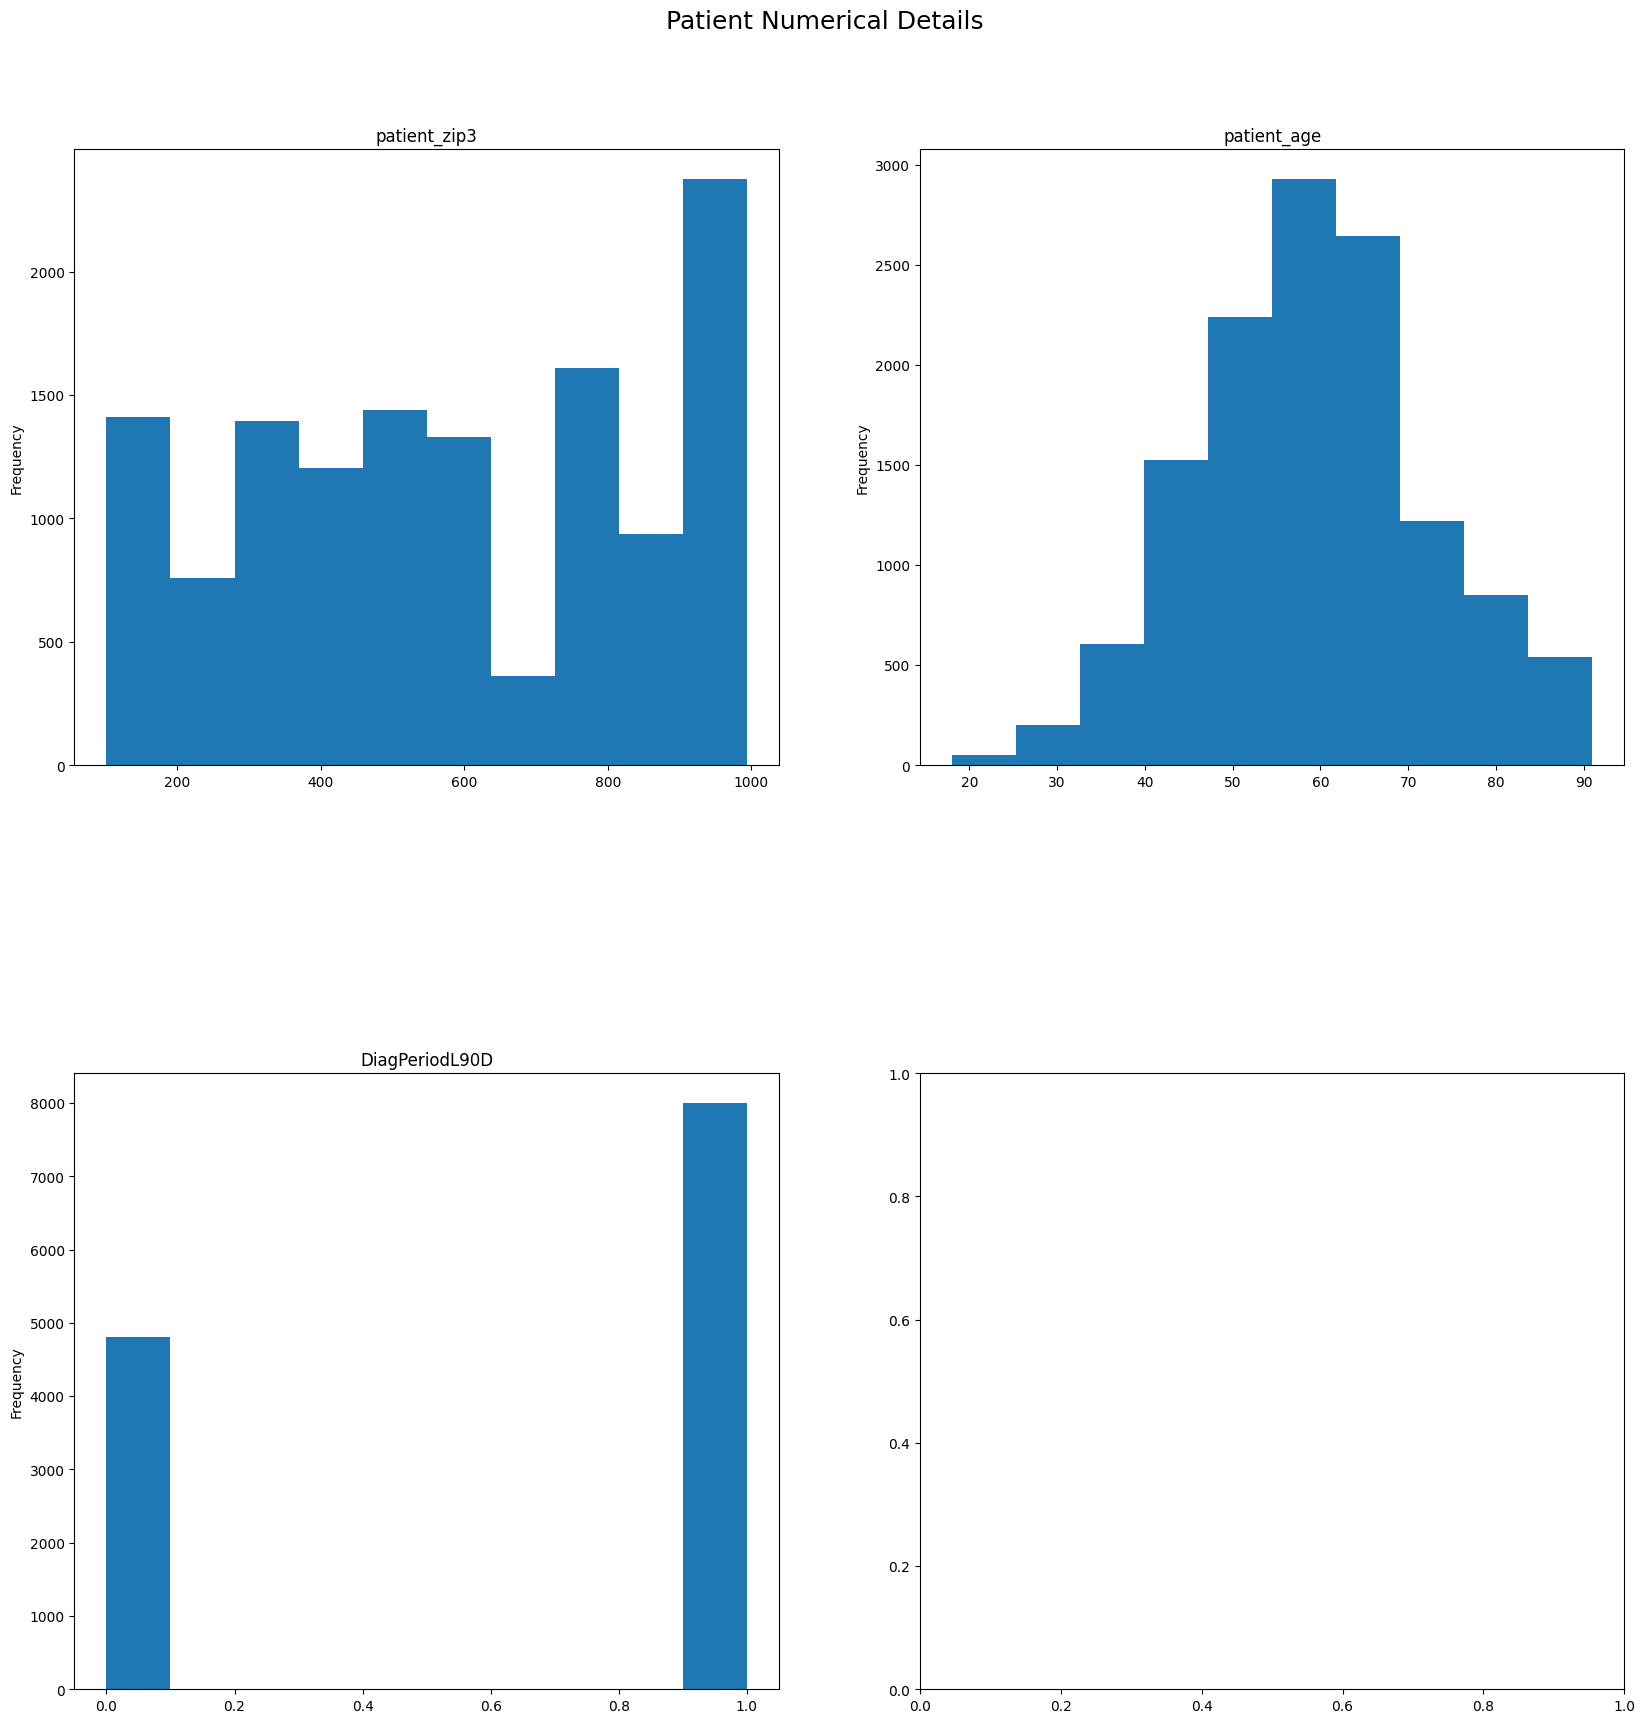

In [18]:
#Drop patient_id
patient_numerical_no_id  = patient_numerical.drop('patient_id', axis = 'columns')
# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Patient Numerical Details", fontsize=18, y=0.95)

# Loop through tickers and axes
for column, ax in zip(patient_numerical_no_id .columns, axs.ravel()):
    # filter df for ticker and plot on specified axes
    patient_numerical_no_id [column].plot(kind = 'hist', ax=ax)

    # Chart formatting
    ax.set_title(column)
    ax.set_xlabel("")

plt.show()


## Observations

1. Patient age: The distribution looks like a normal distribution
3. DiagPeriod: More patients got diagnosed within the first 90 days

In [19]:
patient_numerical_no_id.describe()

,patient_zip3,patient_age,DiagPeriodL90D
count,12823.000000,12823.000000,12823.000000
mean,572.874288,59.172425,0.624503
std,274.917445,13.340693,0.484270
min,101.000000,18.000000,0.000000
25%,331.000000,50.000000,0.000000
50%,554.000000,59.000000,1.000000
75%,840.000000,67.000000,1.000000
max,994.000000,91.000000,1.000000


# Demographic level data

In [20]:
data_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12823 entries, 0 to 12905
Data columns (total 69 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   patient_id                   12823 non-null  int64  
 1   population                   12823 non-null  float64
 2   density                      12823 non-null  float64
 3   age_median                   12823 non-null  float64
 4   age_under_10                 12823 non-null  float64
 5   age_10_to_19                 12823 non-null  float64
 6   age_20s                      12823 non-null  float64
 7   age_30s                      12823 non-null  float64
 8   age_40s                      12823 non-null  float64
 9   age_50s                      12823 non-null  float64
 10  age_60s                      12823 non-null  float64
 11  age_70s                      12823 non-null  float64
 12  age_over_80                  12823 non-null  float64
 13  male            

Only Region and Division are the two categorical variables, which were analyzed in the previous section

In [21]:
demo_cat = data_demo.select_dtypes(include=['object'])
demo_numerical = data_demo.drop(demo_cat.columns, axis=1)

In [22]:
demo_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12823 entries, 0 to 12905
Data columns (total 69 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   patient_id                   12823 non-null  int64  
 1   population                   12823 non-null  float64
 2   density                      12823 non-null  float64
 3   age_median                   12823 non-null  float64
 4   age_under_10                 12823 non-null  float64
 5   age_10_to_19                 12823 non-null  float64
 6   age_20s                      12823 non-null  float64
 7   age_30s                      12823 non-null  float64
 8   age_40s                      12823 non-null  float64
 9   age_50s                      12823 non-null  float64
 10  age_60s                      12823 non-null  float64
 11  age_70s                      12823 non-null  float64
 12  age_over_80                  12823 non-null  float64
 13  male            

## Let's take a look at the numerical data

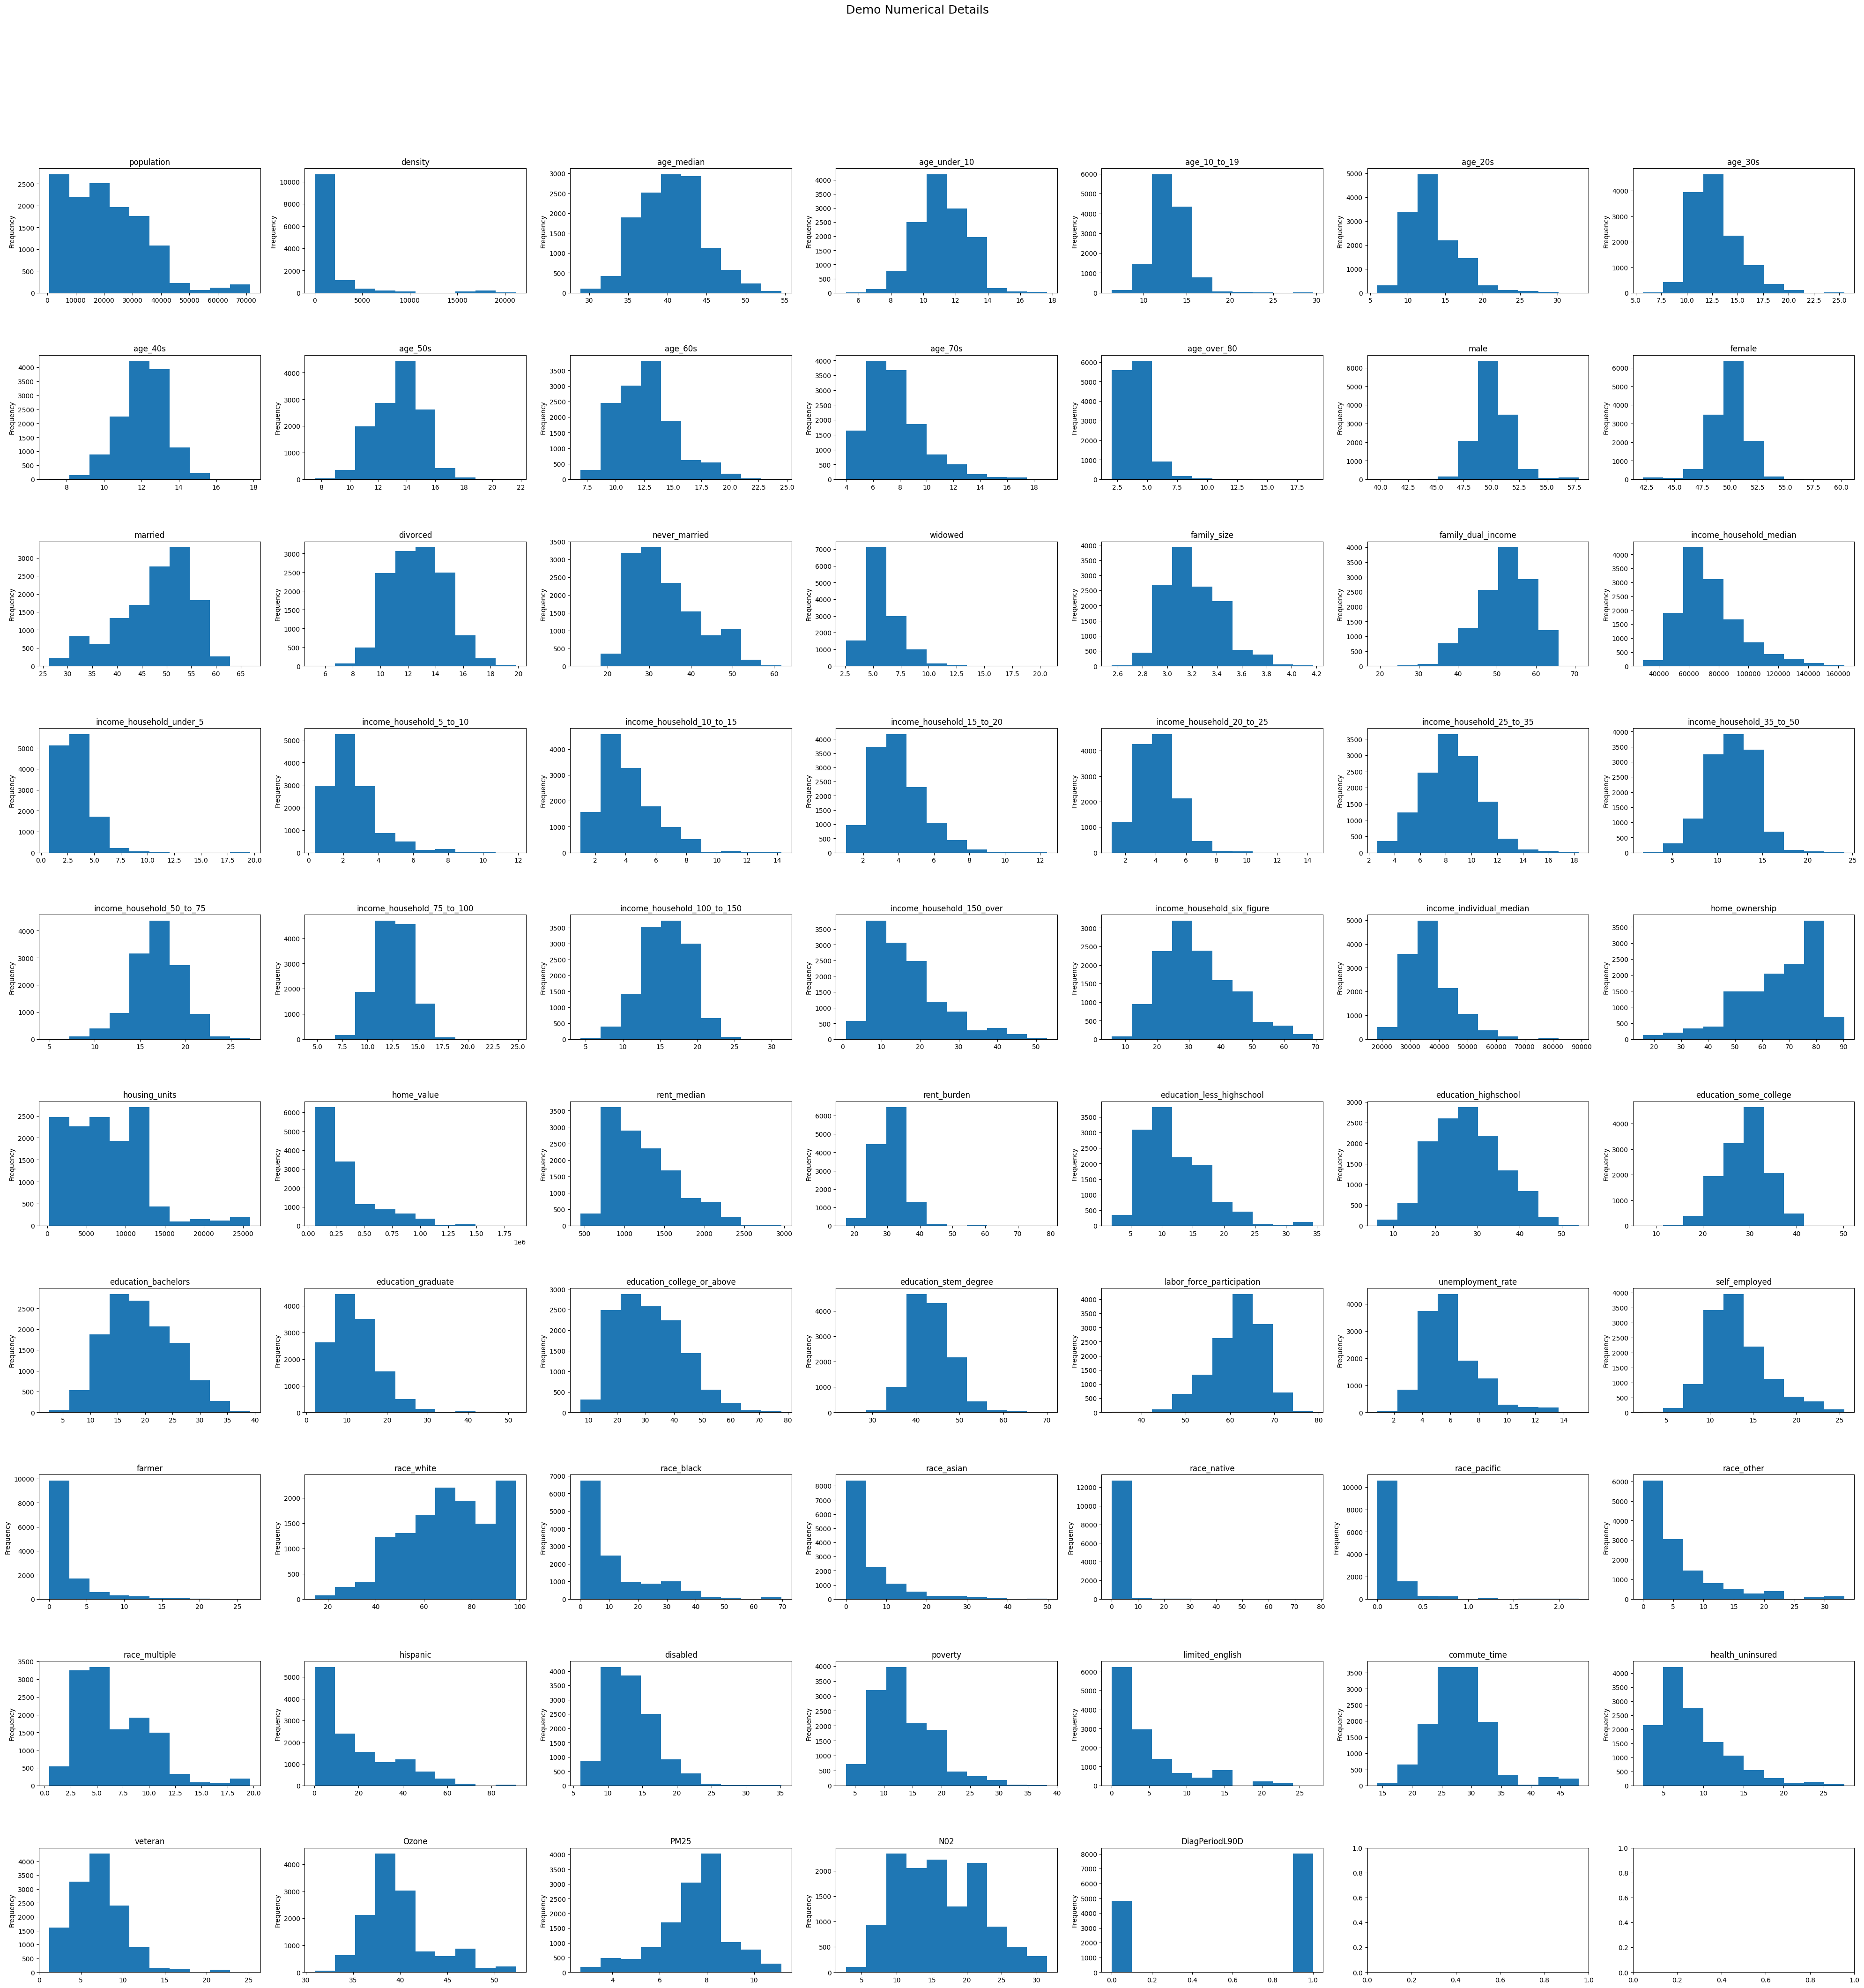

In [23]:
#Drop patient_id
demo_numerical_no_id  = demo_numerical.drop('patient_id', axis = 'columns')

fig, axs = plt.subplots(nrows=10, ncols=7, figsize=(50,50))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Demo Numerical Details", fontsize=18, y=0.95)

# loop through tickers and axes
for column, ax in zip(demo_numerical_no_id .columns, axs.ravel()):
    # filter df for ticker and plot on specified axes
    demo_numerical_no_id [column].plot(kind = 'hist', ax=ax)

    # chart formatting
    ax.set_title(column)
    ax.set_xlabel("")

plt.show()


In [24]:
#Display the descriptive statistics of numerical
demo_numerical_no_id.describe().T.style.background_gradient(cmap='Greens').format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
population,12823.00,20766.17,13905.51,635.55,9463.90,19154.19,30021.28,71374.13
density,12823.00,1582.83,2968.77,0.92,170.55,700.34,1666.52,21172.00
age_median,12823.00,40.51,4.03,28.88,37.13,40.64,42.93,54.57
age_under_10,12823.00,11.13,1.50,5.22,10.16,11.04,12.19,17.68
age_10_to_19,12823.00,12.95,1.89,6.31,11.74,12.93,14.02,29.57
age_20s,12823.00,13.26,3.20,5.92,11.02,12.54,14.97,32.80
age_30s,12823.00,12.87,2.32,5.69,11.29,12.44,14.04,25.47
age_40s,12823.00,12.07,1.23,7.06,11.34,12.13,12.89,17.82
age_50s,12823.00,13.45,1.63,7.53,12.30,13.57,14.58,21.66
age_60s,12823.00,12.62,2.56,6.90,10.62,12.53,13.97,24.51


## Bivariate Analysis

Analyze the correlations between different variables

<ipython-input-25-b23cceaf648f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr() # method='pearson', 'kendall' , 'spearman'


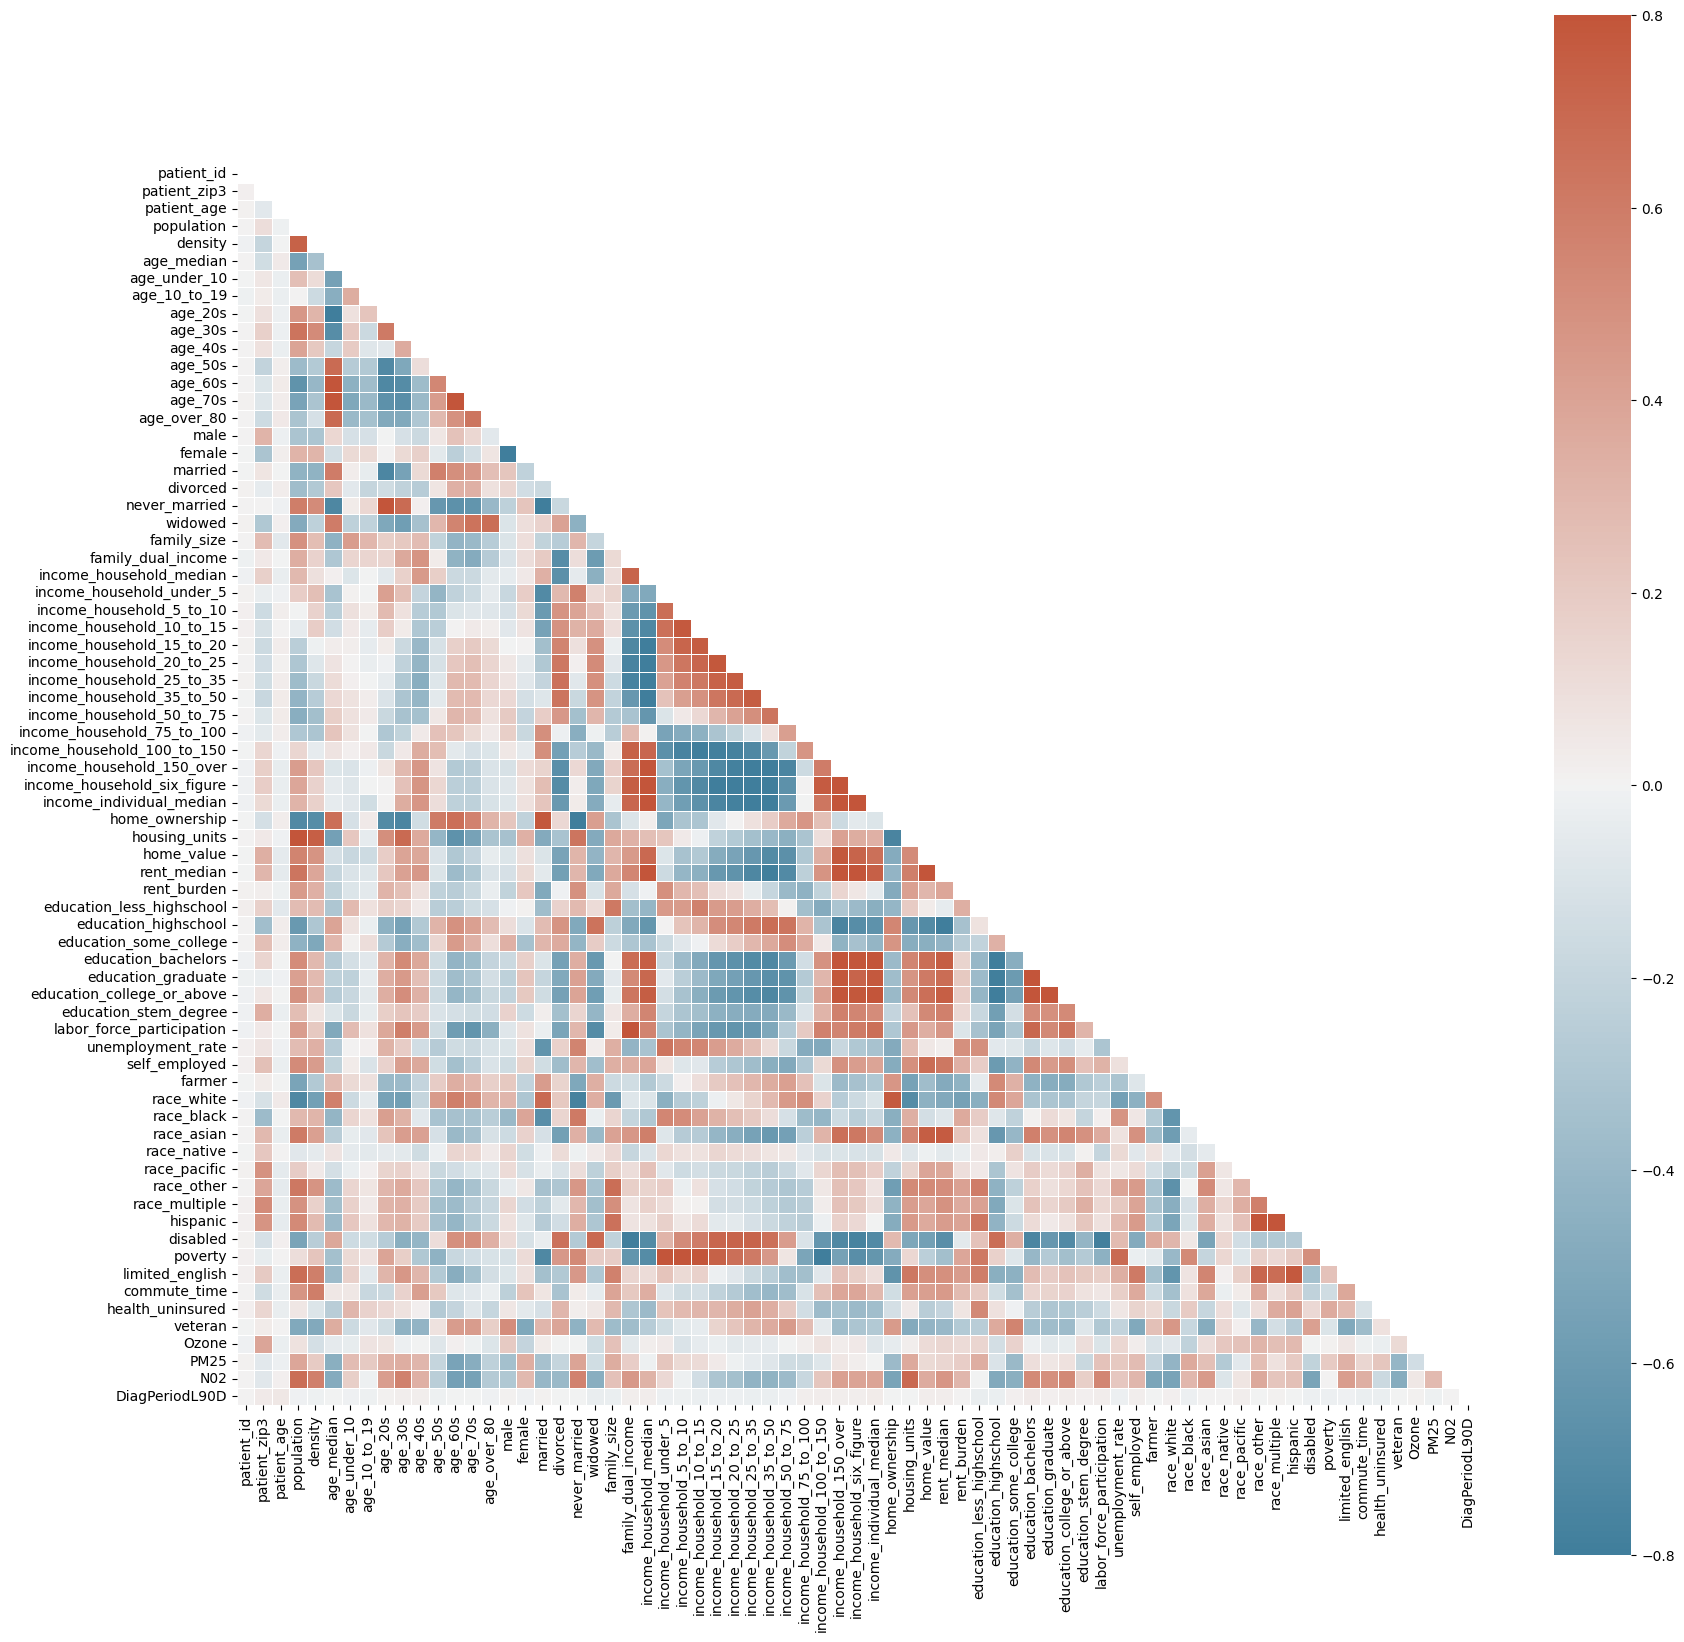

In [25]:
# Calculate correlation matrix
corr = train.corr() # method='pearson', 'kendall' , 'spearman'

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure with a larger size
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-0.8, vmax=0.8, square=True, linewidths=.5)

# Increase font size for better readability
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=10)

plt.show()

We can see multiple significant correlations between the variables indicating that there are redundant features in the data. Therefore, some features will have to be dropped to build a predictive model.

# Analyze distribution of features for datapoints where diagnosis period is within and outside 90 days

In [26]:
# Separate data into diagnosis period above or below 90 days
train_no_id = train.drop('patient_id', axis='columns')
diag_90 = train_no_id[train_no_id['DiagPeriodL90D'] == 1]
diag_over90 = train_no_id[train_no_id['DiagPeriodL90D'] == 0]

In [28]:
# Divide dataset into numerical and categorical features
cat_feats = diag_90.select_dtypes(include=['object'])
numerical_feats = diag_90.drop(cat_feats.columns, axis=1)

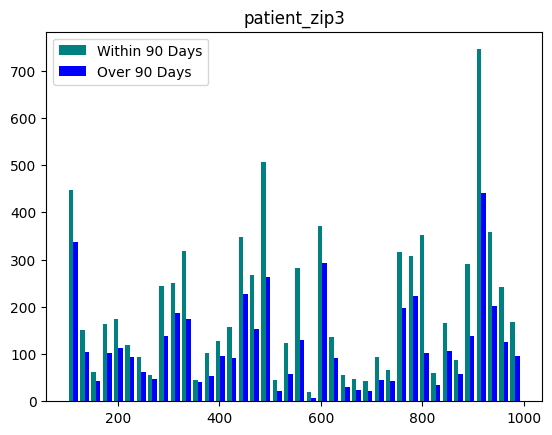

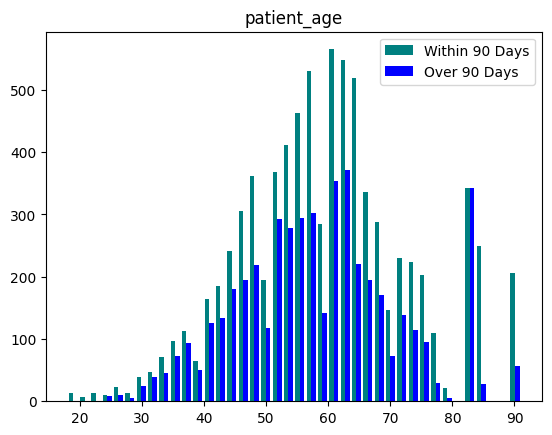

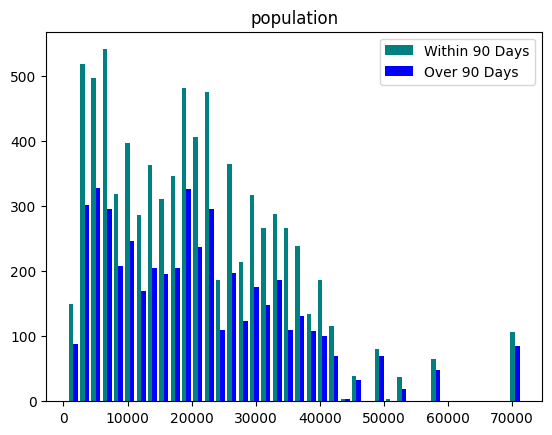

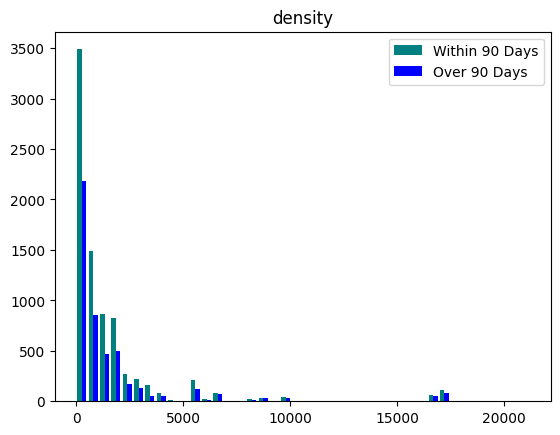

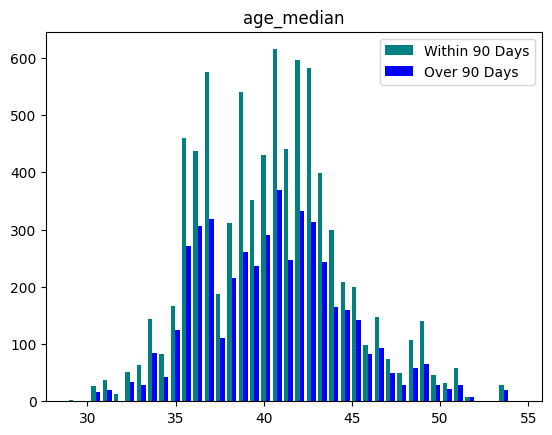

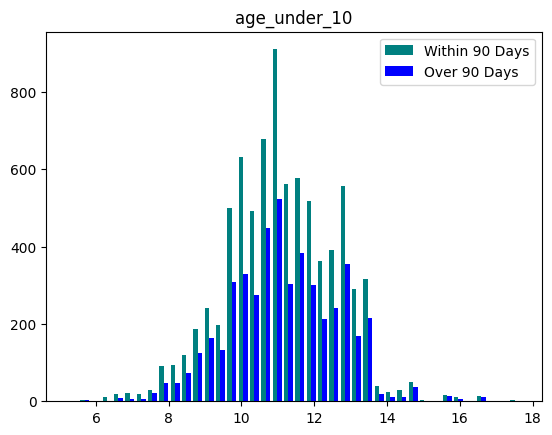

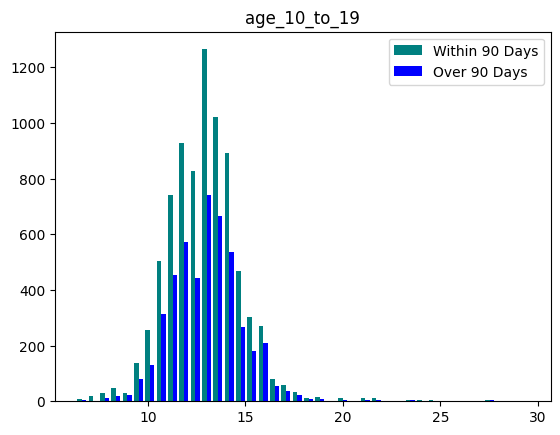

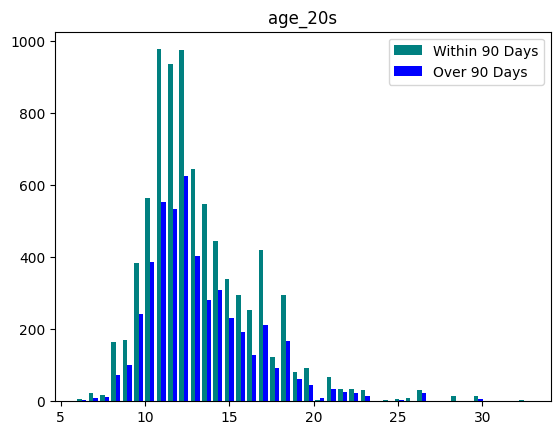

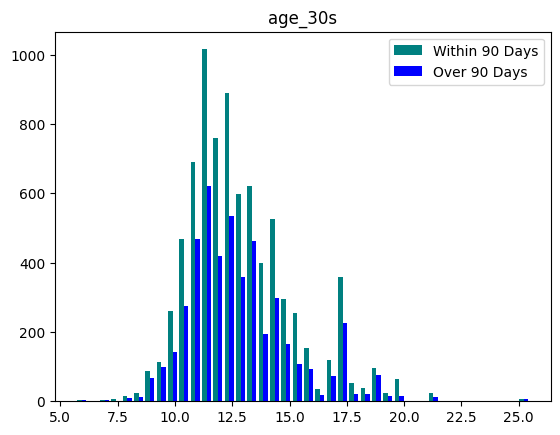

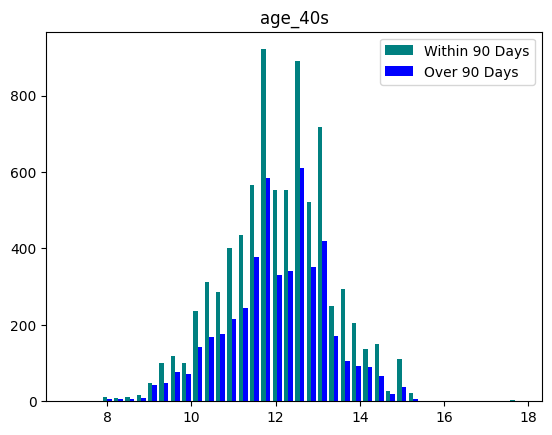

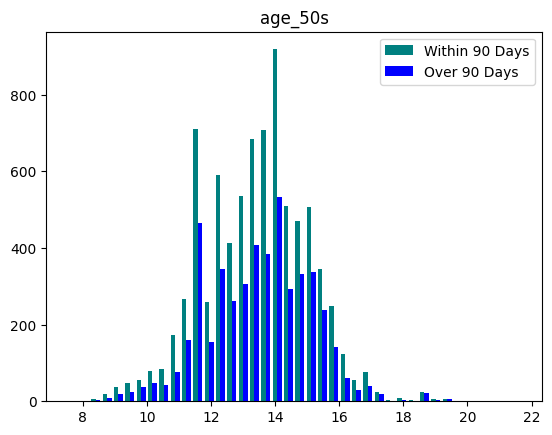

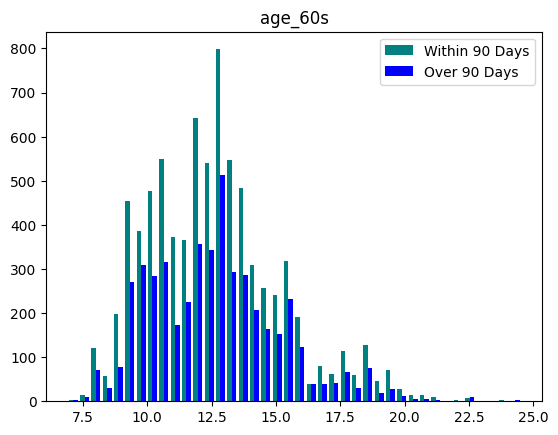

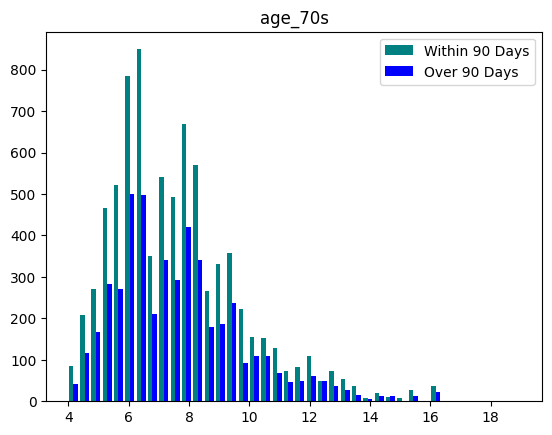

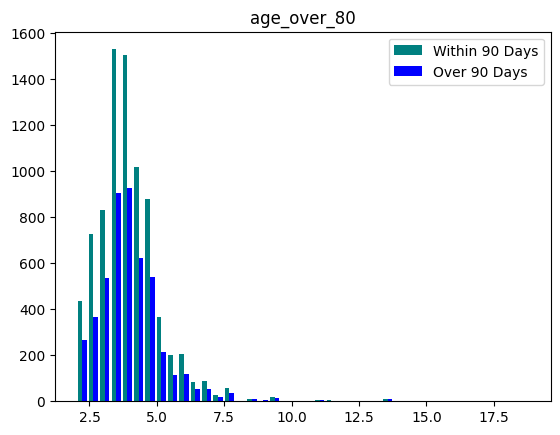

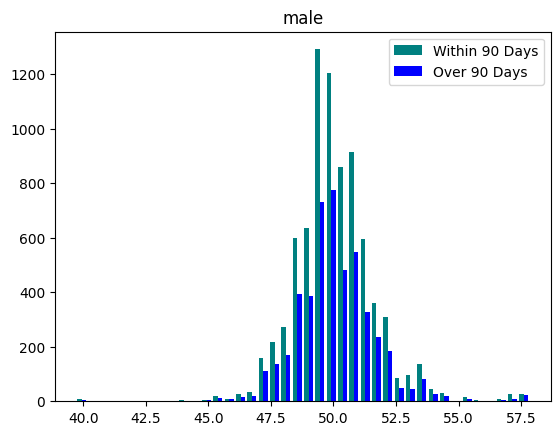

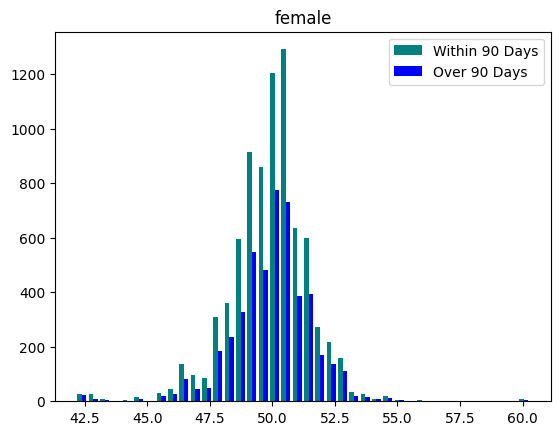

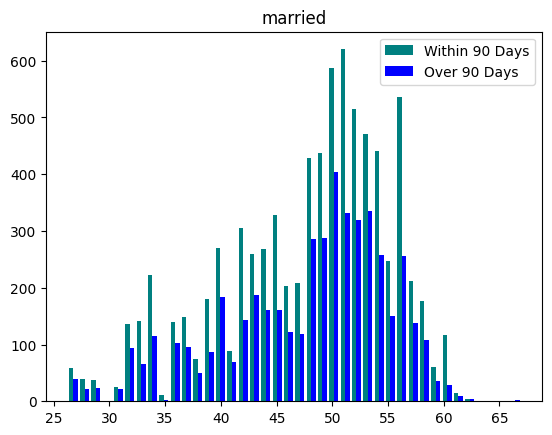

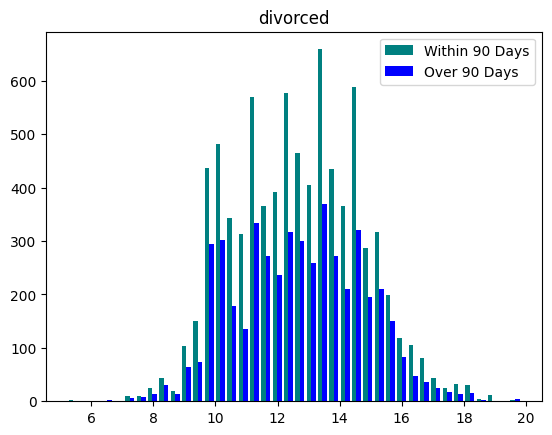

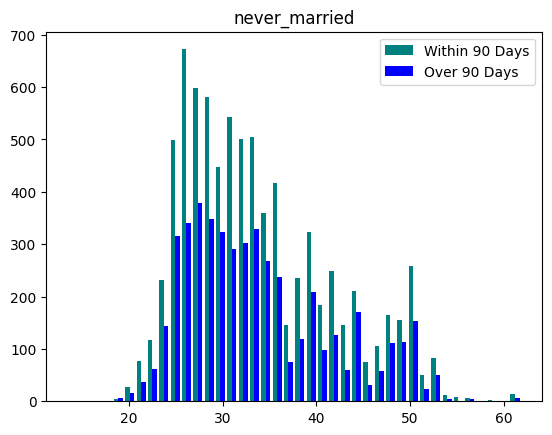

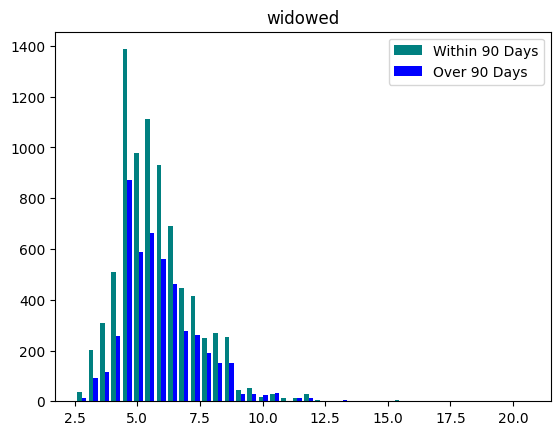

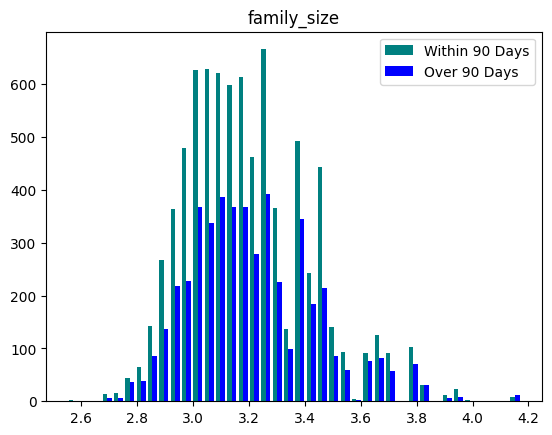

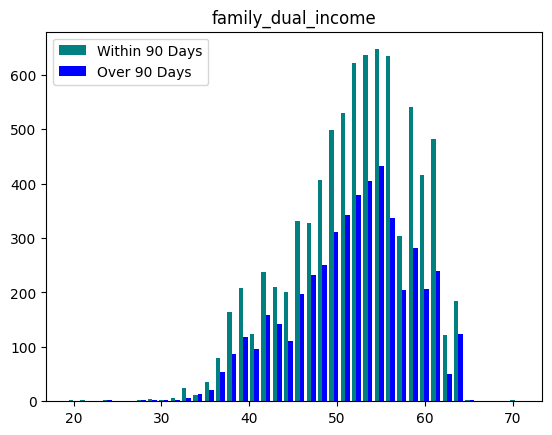

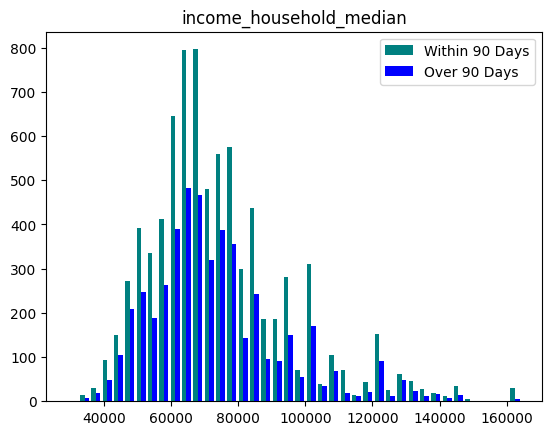

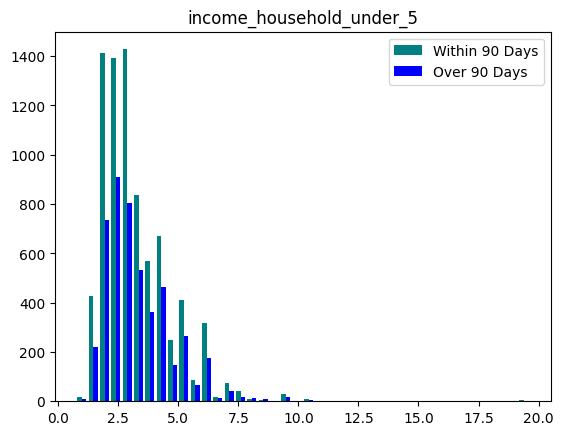

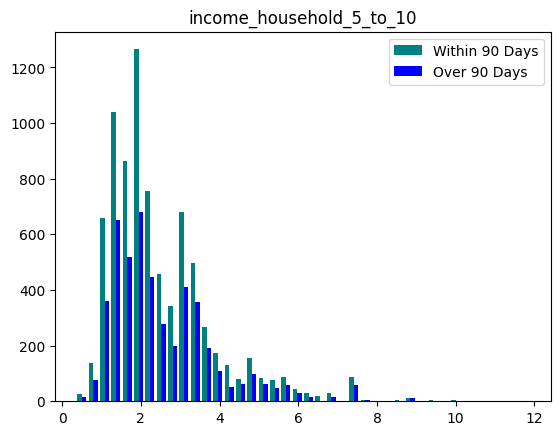

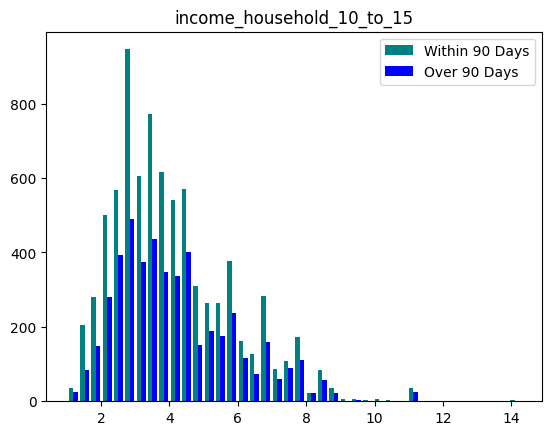

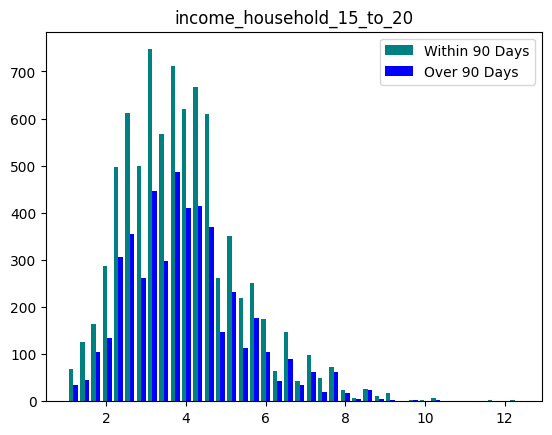

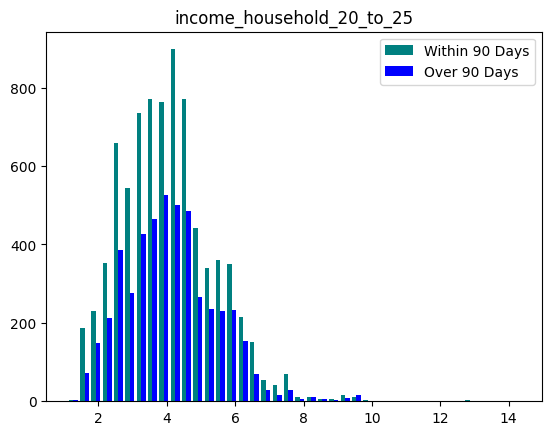

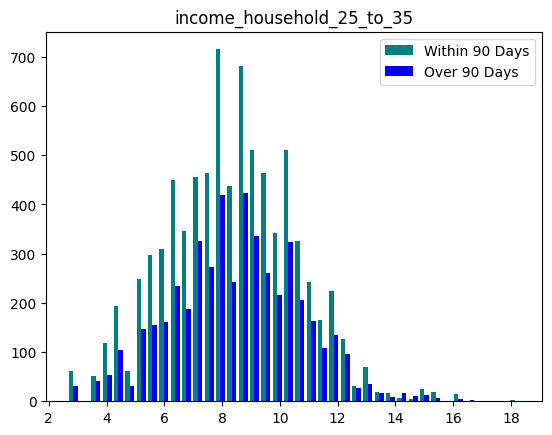

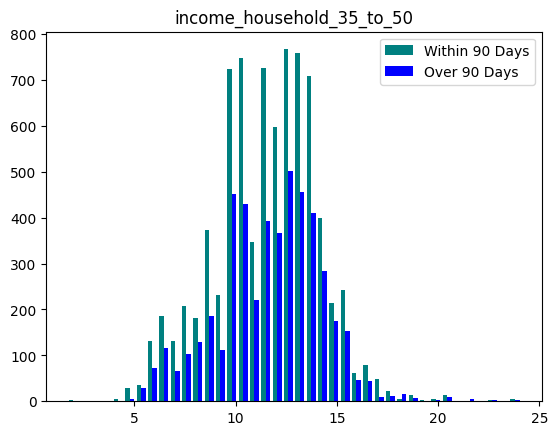

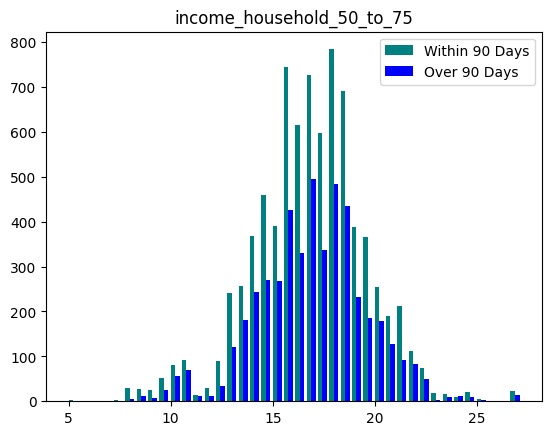

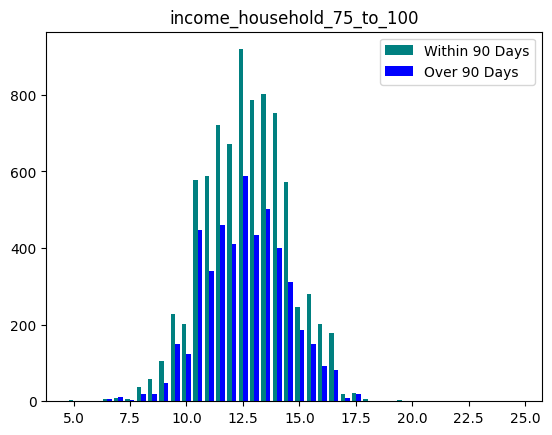

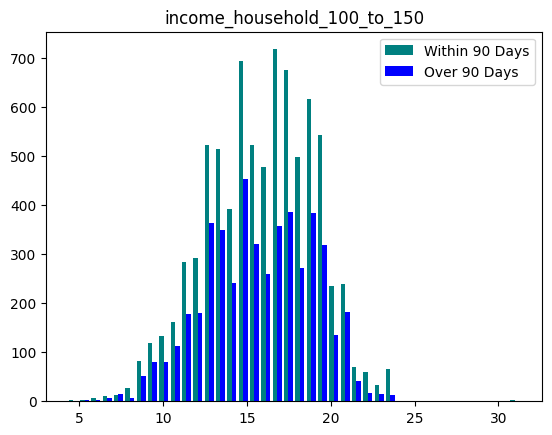

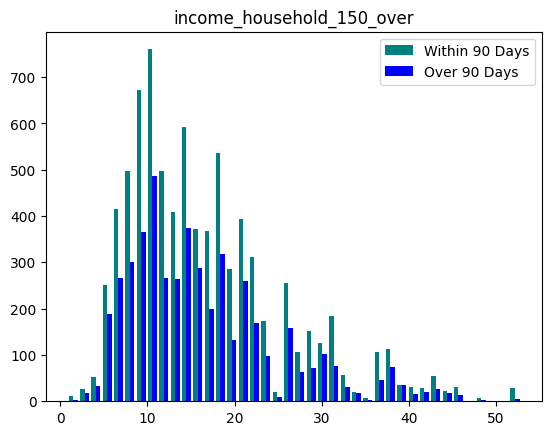

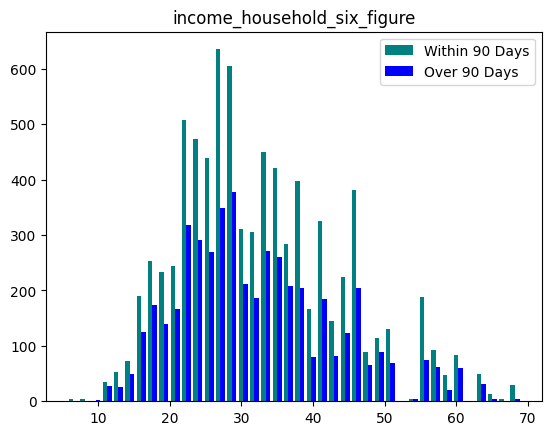

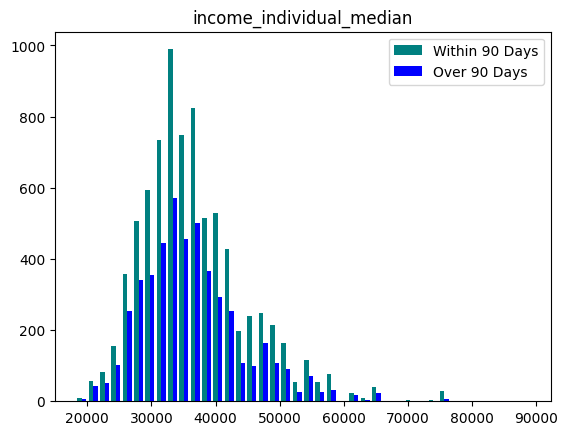

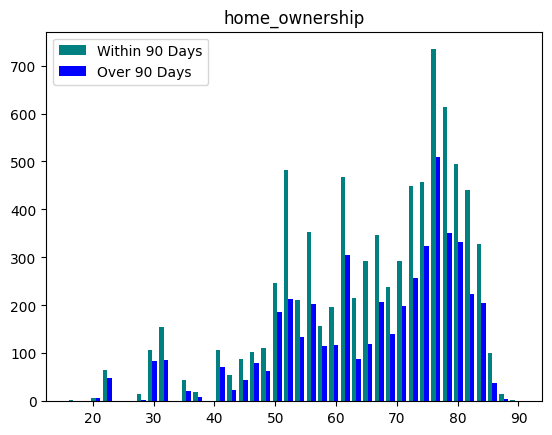

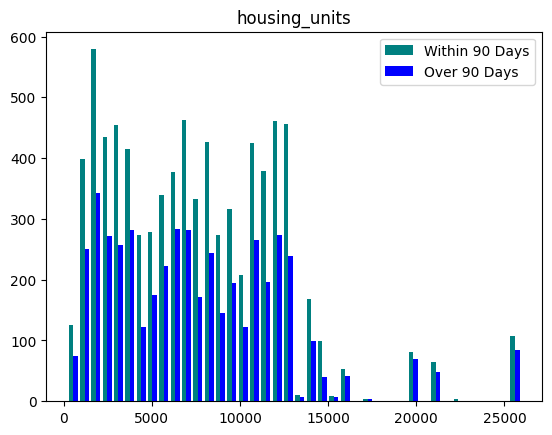

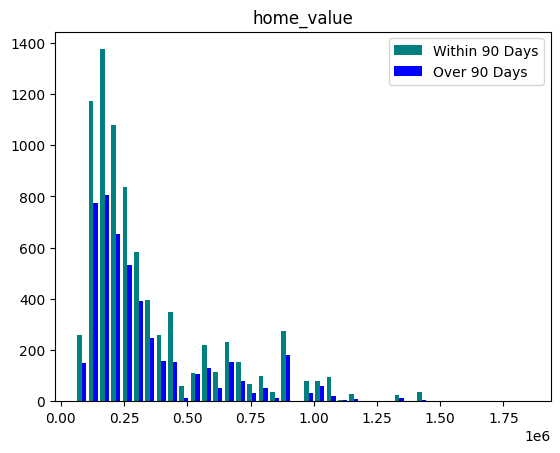

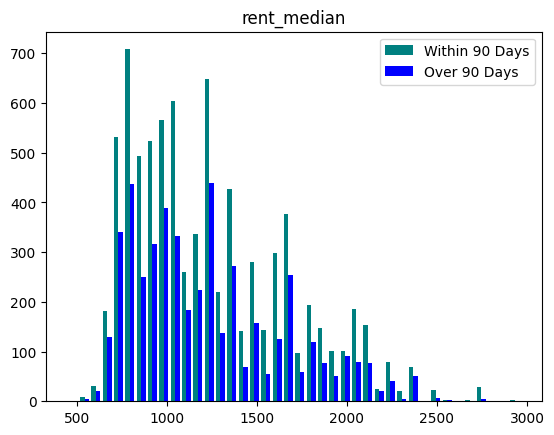

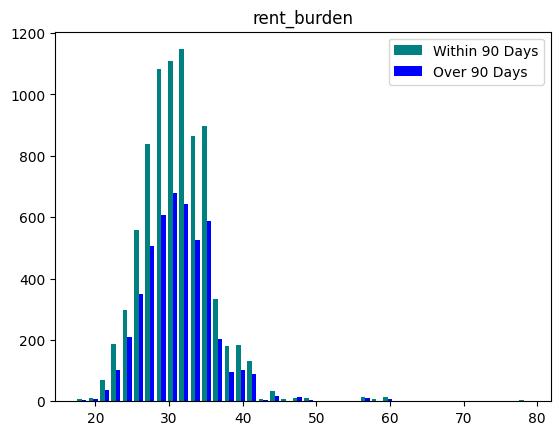

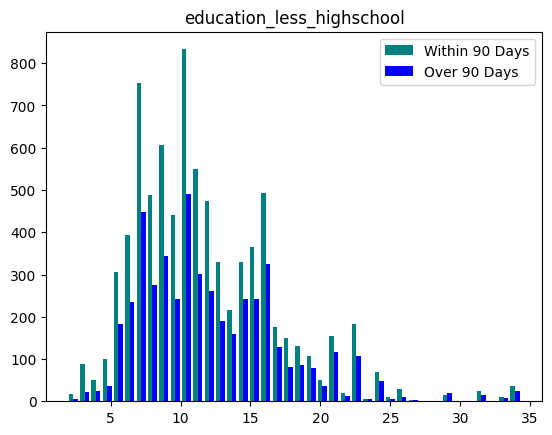

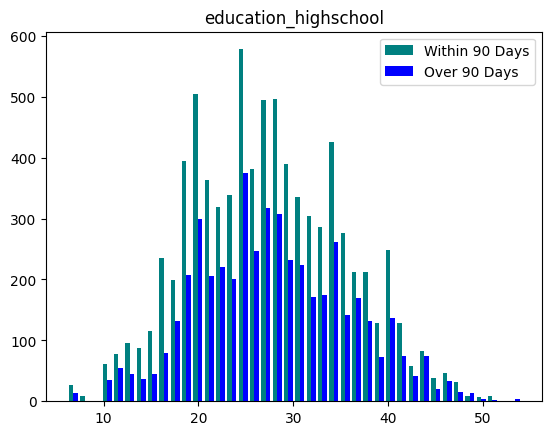

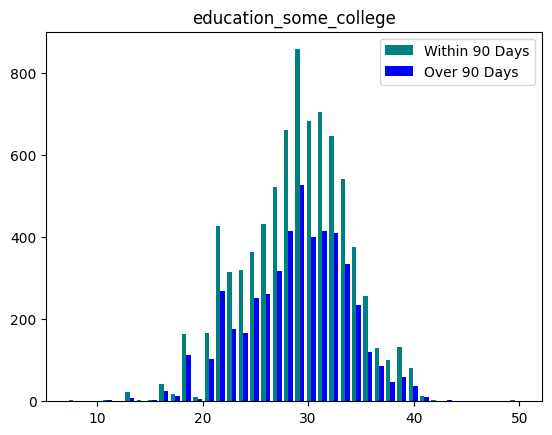

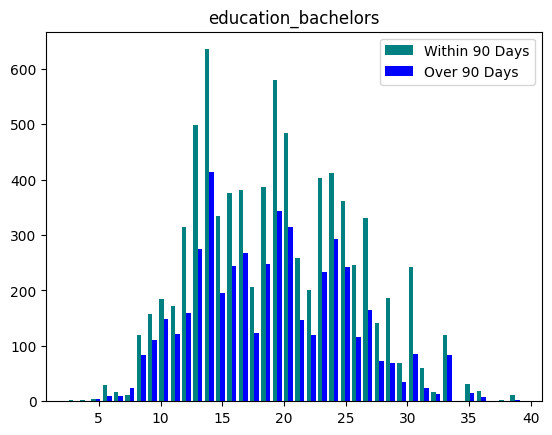

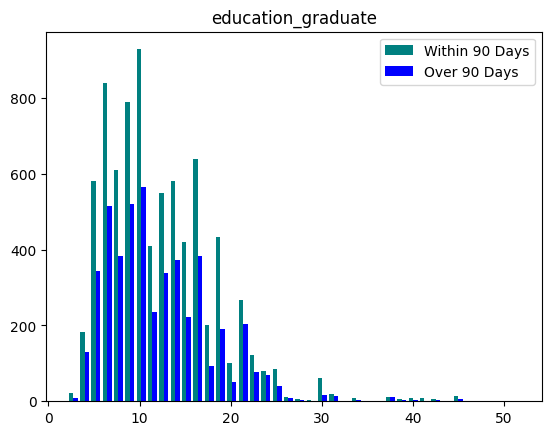

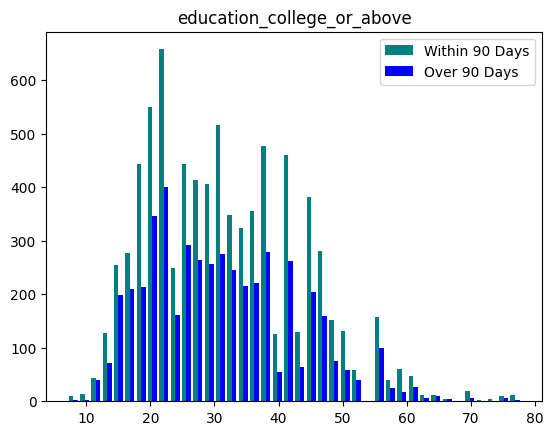

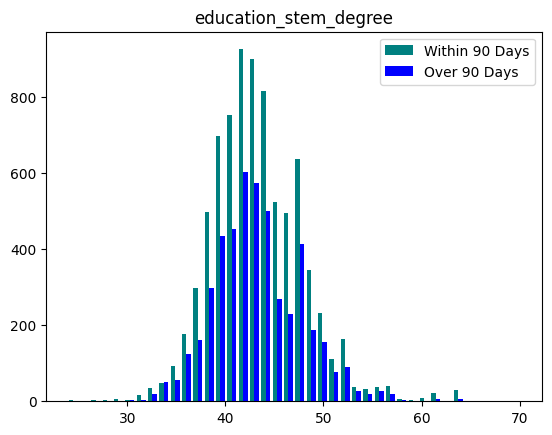

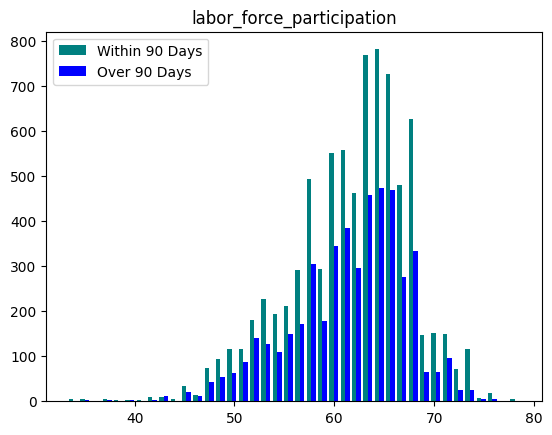

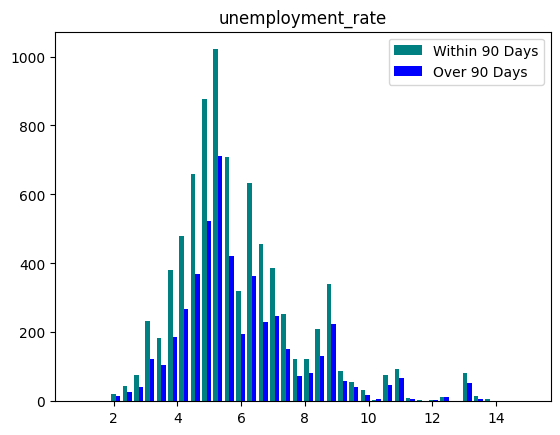

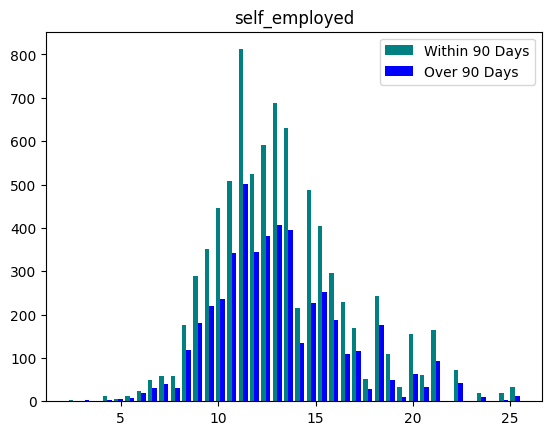

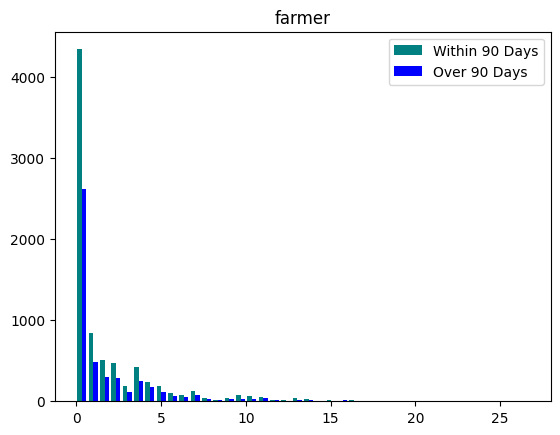

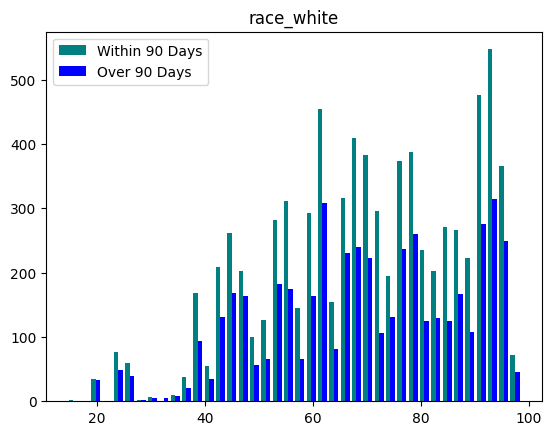

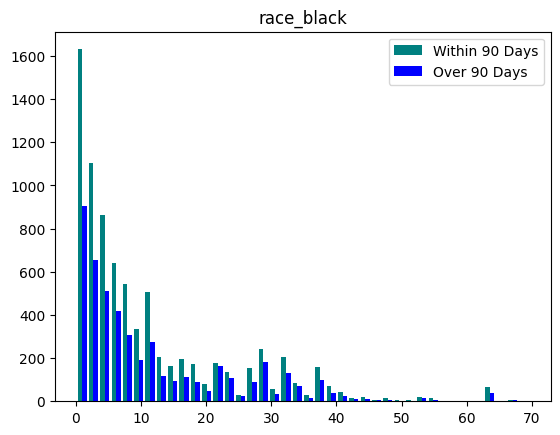

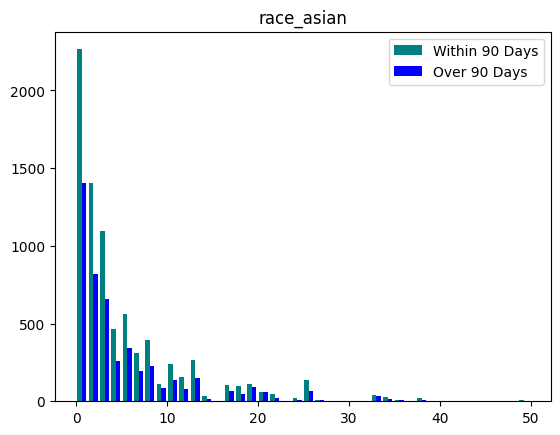

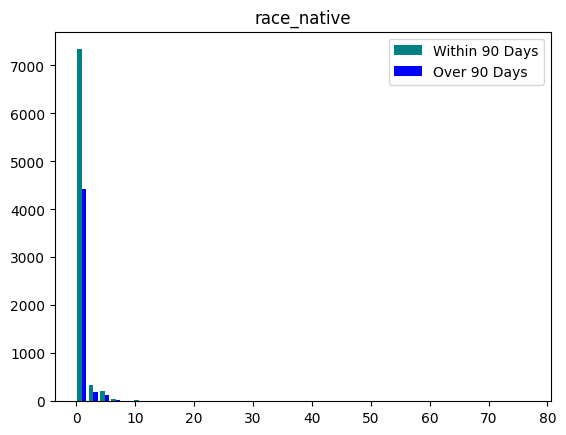

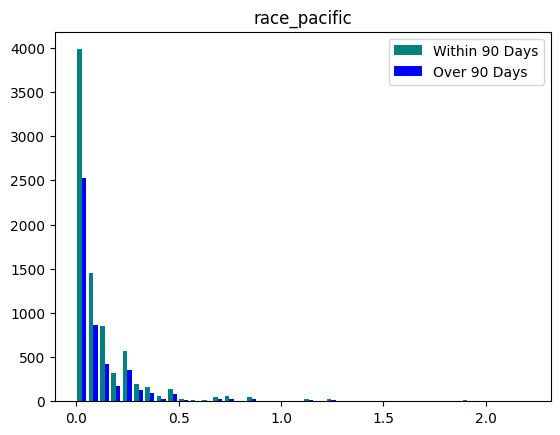

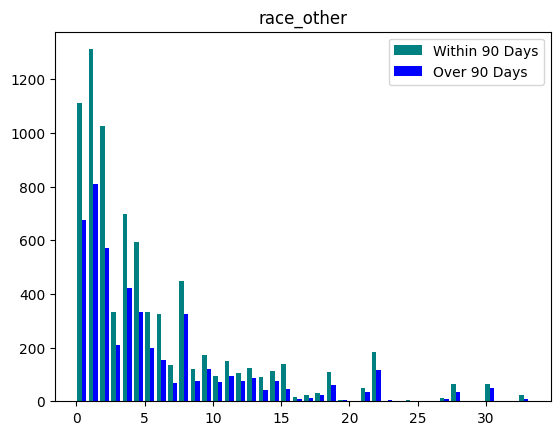

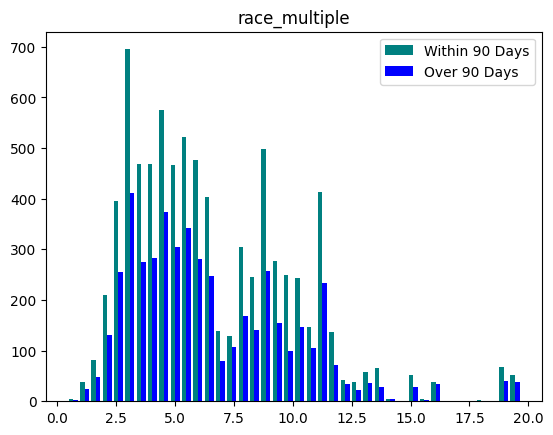

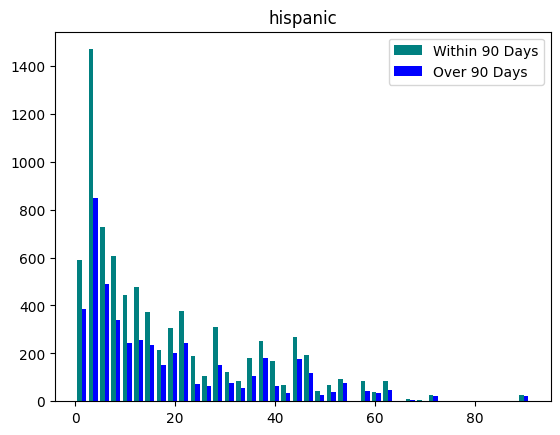

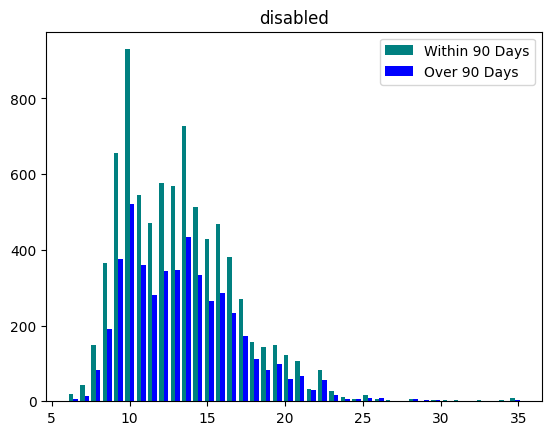

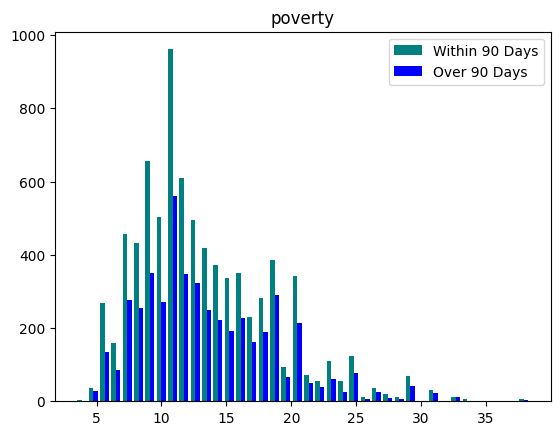

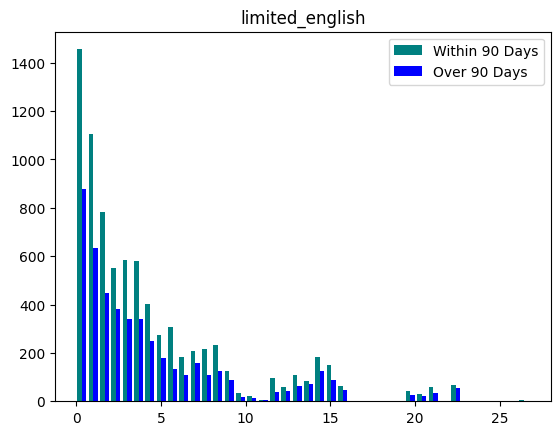

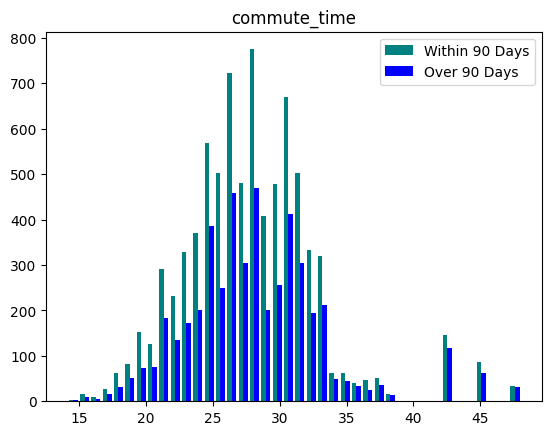

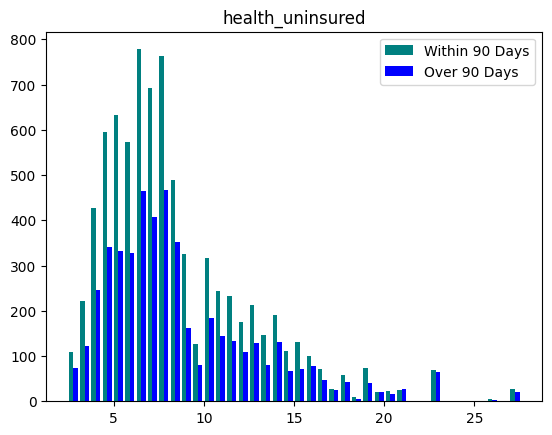

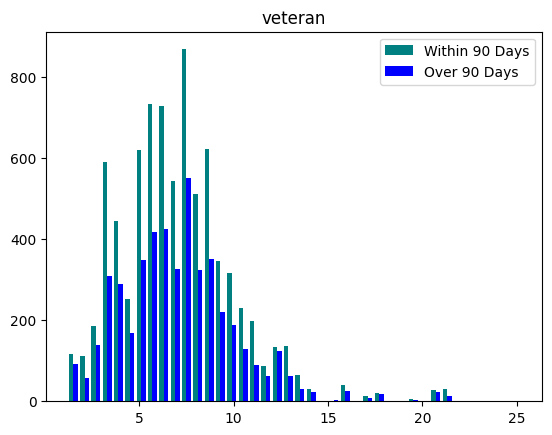

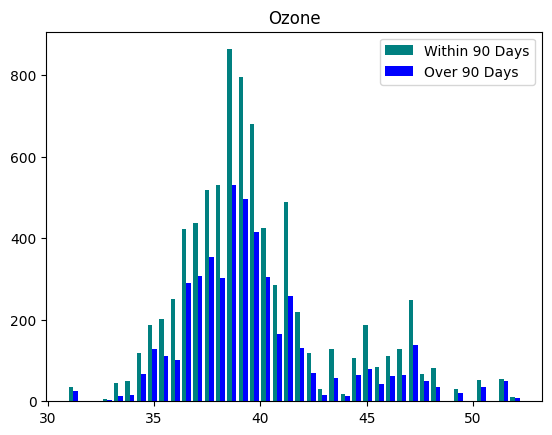

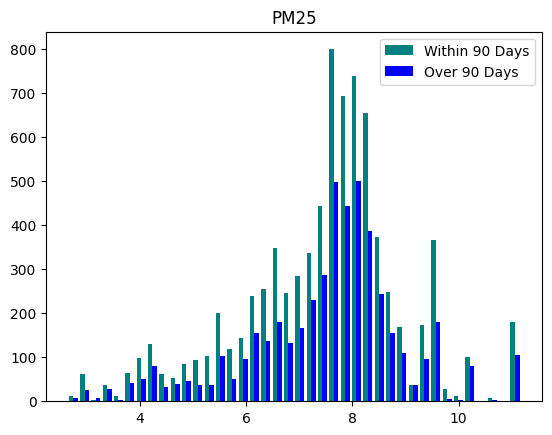

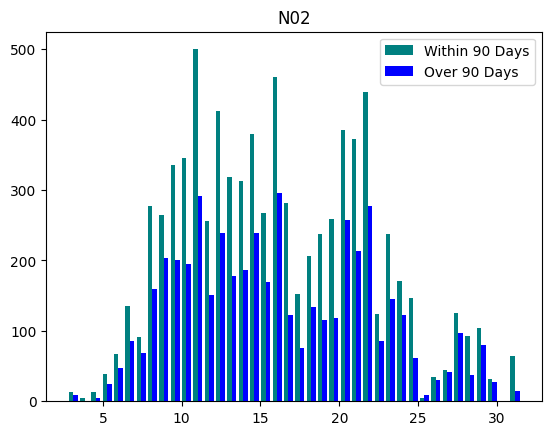

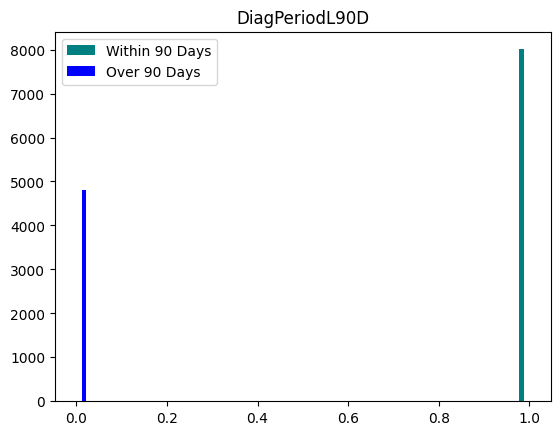

In [ ]:
#Extract numerical features
features = numerical_feats.columns.to_list()

for f in features:
  #Plot histogram of feature comparing the distribution for patients diagnosed within 90 days and over 90 days
  plt.hist([diag_90[f], diag_over90[f]], bins = 40, color =('teal','blue'), label=("Within 90 Days", "Over 90 Days"))
  plt.title(f)
  plt.legend(loc='best')
  plt.show()


Feature distributions for both types of diagnosis periods (above and below 90 days) are similar. There seem to be no outliers.